In [1]:
from loguru import logger

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import logging
import jax
from math import log, exp, sqrt

from bmws import Observation, sim_and_fit, sim_wf
from bmws.betamix import forward, BetaMixture
from bmws.data import Dataset
from bmws.estimate import empirical_bayes, estimate, jittable_estimate, _beta_pdf
from bmws.sim import sim_admix
rng = np.random.default_rng()

# New data format

Create a list of "records" and then call `data = Dataset.from_records()`. Each record is of the form:

    rec = {
        't': t,  # time of observation (gens before present)
        'theta': theta  # [K] admixture proportions,
        'obs': (n, d)   # tuple: n = # of observed alleles, d = # of derived alleles.
    }
    
(For diploid data, $n=2$, while for pseuodhaploid data $n=1$)

## New objective function
Additional regularization terms have been added. The estimand $\mathbf{s}\in\mathbb{R}^{T\times K}$ is now a matrix with $T$ rows (time points) and $K$ columns/populations. The new objective function is:

$$f(\mathbf{s}) = -\mathrm{loglik}(\text{data}\mid N_e,\mathbf{s}) 
+ \alpha \sum_k \sum_{t=2}^T (s_{k,t} - s_{k,t-1})^2 
+ \beta \sum_t \sum_{k_1,k_2 \in [K]} (s_{k_1,t} - s_{k_2,t})^2 
+ \gamma \Vert \mathbf{s} \Vert_*$$

so:

- $\alpha$ controls smoothness "across time" of the $s_{kt}$ for each population $k$
- $\beta$ controls smoothness "between groups"
- $\gamma$ penalizes the rank of the matrix $s$, setting $\gamma\to\infty$ makes each estimated $s$ become a scalar multiple of the other.

$\beta$ and $\gamma$ sort of aim at the same goal, we'll need to experiment to see which makes more sense.

In [3]:

#Load data
def read_data(pop, k_tag=""):

    admixture_proportions=pd.read_csv("data/"+pop+k_tag+"_sample_info.txt", sep="\t")
    admixture_proportions["generation"]=[int(x) for x in round(admixture_proportions["Date"]/30)]
    admixture_proportions=admixture_proportions[(admixture_proportions['Date'] <=10000)]

    #merge allele counts 
    counts=pd.read_csv("data/"+pop+"_snp_acs.raw", sep=" ")
    snps=list(counts.columns)[6:]
    data=pd.merge(admixture_proportions, counts, on="IID")

    #Parameters for data matrices
    T=max(data["generation"])+1
    N=max(data["generation"].value_counts().values)
    K=admixture_proportions.shape[1]-7
    datasets=[]
    for snp in snps:
        records = []
        for gen, count in data["generation"].value_counts().items():
            this_data=data[data["generation"]==gen]
            M=this_data.shape[0]
            for i in range(M):
                if not this_data[snp].isna().iloc[i]:
                    rec = {'t': gen}
                    rec['obs'] = (1, int(this_data[snp].values[i] / 2))
                    rec['theta'] = [this_data["k"+str(k+1)].iloc[i] for k in range(K-1)]
                    rec['theta'].append(1 - sum(rec['theta']))
                    records.append(rec)
        
        datasets.append(Dataset.from_records(records))
        
    return datasets, snps

In [4]:
#Run analysis - no longer fails!
def run_analysis(data, alpha=1e4, beta=1e4, gamma=0, em_iterations=3):
    M=100
    Ne=np.full([data.T, data.K], 1e4)
    Ne_fit=Ne
    s = np.zeros([data.T, data.K])
    ab = np.ones([2, data.K]) + 1e-4
    estimate_kwargs={"alpha": alpha, "beta": beta, "gamma": gamma}

#    with jax.debug_nans(True):
#        for i in range(em_iterations):
#            logger.info("EM iteration {}", i)
#            ab, prior = empirical_bayes(ab0=ab, s=s, data=data, Ne=Ne, M=M)
#            logger.info("ab: {}", ab)
#            s = estimate(data=data, Ne=Ne_fit, prior=prior, **estimate_kwargs)
#            logger.info("s: {}", s)

    for i in range(em_iterations):
        ab, prior = empirical_bayes(ab0=ab, s=s, data=data, Ne=Ne, M=M)
        s = estimate(data=data, Ne=Ne_fit, prior=prior, **estimate_kwargs)
            
    return s

snp_4_100142302_C(/A)


2024-09-16 13:54:16.659 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[1.0001    , 1.00329994, 1.01333889],
       [1.0001    , 1.00318395, 1.0001    ]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(269.77757287, dtype=float64, weak_type=True), success=False, status=2, iter_num=1, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(48, dtype=int32), num_jac_eval=Array(48, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-09-16 13:58:06.688 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[-1.52561888e-02, -4.45915646e-02, -6.68769841e-02],
       [-1.51539690e-02, -4.45915401e-02, -6.68753949e-02],
       [-1.50418070e-02, -4.45914252e-02, -6.68720184e-02],
       [-1.49276976e-02, -4.45912771e-02, -6.68665221e-02],
       [-1.48273511e-02, -4.45909362e-02, -6.68583511e-02],
       [-1.48297336e-02, -4.45905128e-02, -6.68469477e-02],
       [-1.48531692e-02, -4.45897418e-02, -6.68319661e-02],
       [-1.4948

2024-09-16 13:58:15.082 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[  1.0001    ,  45.18230001, 100.        ],
       [  1.0001    , 100.        ,   1.0001    ]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(252.00250628, dtype=float64, weak_type=True), success=True, status=0, iter_num=19, hess_inv=LbfgsInvHessProduct(sk=[[ 0.00000000e+00  8.33841753e+00  1.88505630e+01  0.00000000e+00
   1.85056370e+01  0.00000000e+00]
 [ 0.00000000e+00  8.15516025e+00  1.84786232e+01  0.00000000e+00
   1.81495247e+01  0.00000000e+00]
 [ 0.00000000e+00  5.37665301e+00  5.57012612e+00  0.00000000e+00
   5.55507069e+00  0.00000000e+00]
 [ 0.00000000e+00  1.87691094e+00  9.16196952e+00  0.00000000e+00
   9.60424691e+00  0.00000000e+00]
 [ 0.00000000e+00 -7.98982502e-01  1.38241727e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  6.40188277e-02  3.30065227e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  3.28534083e-0

snp_4_100142302_C(/A)
rs17843625_G(/A)


2024-09-16 14:01:40.255 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[1.0001    , 8.97374257, 3.52248413],
       [1.06410105, 7.2735992 , 7.4480129 ]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(151.76209016, dtype=float64, weak_type=True), success=True, status=0, iter_num=14, hess_inv=LbfgsInvHessProduct(sk=[[ 0.00000000e+00  2.70272040e-01  8.77665094e-02  2.60619591e-02
   2.23147062e-01  2.14771022e-01]
 [ 0.00000000e+00  2.96628741e-03  9.85426656e-04  1.82189797e-04
   2.53050546e-03  2.41078876e-03]
 [ 0.00000000e+00  6.87262298e-05  1.71813960e-05  7.67082462e-06
   5.70929159e-05  5.68607338e-05]
 [ 0.00000000e+00  5.49679225e-01  2.94767163e-01  1.43195930e-01
   3.58160308e-01  4.07893788e-01]
 [ 0.00000000e+00  1.33610330e+00  5.33767211e-01  3.22240928e-01
   1.06239524e+00  1.01285318e+00]
 [ 0.00000000e+00  1.50185595e+00  5.55062028e-01 -7.95447548e-03
   1.26397167e+00  1.15464229e+00]
 [ 0.00000000e+00  2.49577220e+00  9.9900897

2024-09-16 14:04:42.557 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[1.0001    , 8.75635586, 3.48722583],
       [2.68057618, 7.65729878, 7.6250207 ]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(118.06534228, dtype=float64, weak_type=True), success=False, status=2, iter_num=8, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(101, dtype=int32), num_jac_eval=Array(101, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-09-16 14:08:40.122 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[-1.03527041e-01, -6.50075297e-02, -1.23806419e-01],
       [-1.03513262e-01, -6.50035810e-02, -1.23776834e-01],
       [-1.03483983e-01, -6.49955427e-02, -1.23718710e-01],
       [-1.03427614e-01, -6.49835575e-02, -1.23630106e-01],
       [-1.03346580e-01, -6.49674875e-02, -1.23513890e-01],
       [-1.03233796e-01, -6.49471743e-02, -1.23366489e-01],
       [-1.03081004e-01, -6.49229186e-02, -1.23191810e-01],
       [-1.02

rs17843625_G(/A)
rs10829106_C(/T)


2024-09-16 14:09:15.940 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[ 90.93964944,   1.0001    , 100.        ],
       [ 95.94154224, 100.        ,  89.13121868]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(403.31571179, dtype=float64, weak_type=True), success=True, status=0, iter_num=24, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(132, dtype=int32), num_jac_eval=Array(132, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-09-16 14:18:21.650 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[ 8.90366910e-03, -7.66079771e-03, -8.12502921e-02],
       [ 8.92738683e-03, -7.65748581e-03, -8.12207215e-02],
       [ 8.96526197e-03, -7.65238674e-03, -8.11621543e-02],
       [ 9.03987600e-03, -7.64243736e-03, -8.10749487e-02],
       [ 9.12785899e-03, -7.62981105e-03, -8.09602386e-02],
       [ 9.24186153e-03, -7.61329085e-03, -8.08186001e-02],
       [ 9.35844858e-03, -7.59273648e-03, -8.06505675e-02],
 

2024-09-16 14:18:37.248 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[ 90.93784752,   1.0001    , 100.        ],
       [ 95.94333027, 100.        ,  89.13050545]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(392.09488586, dtype=float64, weak_type=True), success=False, status=2, iter_num=1, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(52, dtype=int32), num_jac_eval=Array(52, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-09-16 14:21:45.628 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[ 8.68265267e-03, -7.60002389e-03, -8.18430459e-02],
       [ 8.71250618e-03, -7.60057172e-03, -8.18105301e-02],
       [ 8.76410363e-03, -7.59923554e-03, -8.17452310e-02],
       [ 8.84035922e-03, -7.59421324e-03, -8.16508304e-02],
       [ 8.92225775e-03, -7.58316039e-03, -8.15266495e-02],
       [ 9.03404342e-03, -7.56480979e-03, -8.13751933e-02],
       [ 9.13612606e-03, -7.54250665e-03, -8.11957527e-02],
   

rs10829106_C(/T)
rs174548_C(/G)


2024-09-16 14:22:02.800 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[1.92627394, 1.0001    , 1.0001    ],
       [4.54007964, 5.97911787, 4.42090582]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(387.56315665, dtype=float64, weak_type=True), success=True, status=0, iter_num=8, hess_inv=LbfgsInvHessProduct(sk=[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  4.76592672e-01
   8.71531272e-01  6.60757752e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  4.95092710e-01
   7.21525417e-01  4.64219184e-01]
 [ 3.74243268e-01  0.00000000e+00  0.00000000e+00  9.34468280e-01
   1.35403682e+00  9.02750038e-01]
 [ 5.57903421e-01  0.00000000e+00  0.00000000e+00  1.46168734e+00
   1.83952359e+00  1.25873663e+00]
 [-6.02081297e-03  0.00000000e+00  0.00000000e+00  1.71205104e-01
   1.91324907e-01  1.33605942e-01]
 [ 4.42748693e-05  0.00000000e+00  0.00000000e+00  8.68935791e-04
   9.99544066e-04  6.84190709e-04]
 [ 3.79296470e-06  0.00000000e+00  0.00000000

2024-09-16 14:26:19.748 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[1.9262381 , 1.0001    , 1.0001    ],
       [4.54009064, 5.97912166, 4.42091184]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(355.9667203, dtype=float64, weak_type=True), success=False, status=2, iter_num=1, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(36, dtype=int32), num_jac_eval=Array(36, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-09-16 14:28:32.074 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[ 5.70117028e-02,  1.85029052e-02,  1.46097086e-02],
       [ 5.70099150e-02,  1.85027505e-02,  1.46107663e-02],
       [ 5.70065254e-02,  1.85024422e-02,  1.46128686e-02],
       [ 5.70017069e-02,  1.85014792e-02,  1.46160045e-02],
       [ 5.69956182e-02,  1.84999169e-02,  1.46201488e-02],
       [ 5.69884035e-02,  1.84940040e-02,  1.46252689e-02],
       [ 5.69801907e-02,  1.84830028e-02,  1.46313185e-02],
       [ 5.69710

rs174548_C(/G)
rs12913832_G(/A)


2024-09-16 14:34:10.188 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[  1.0001    ,   1.0001    ,   3.87000421],
       [100.        , 100.        ,  90.8313718 ]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(6.85265377, dtype=float64, weak_type=True), success=True, status=0, iter_num=20, hess_inv=LbfgsInvHessProduct(sk=[[0.00000000e+00 0.00000000e+00 1.01205619e-03 0.00000000e+00
  0.00000000e+00 3.28351253e-05]
 [0.00000000e+00 0.00000000e+00 4.76783927e-05 0.00000000e+00
  0.00000000e+00 4.41975029e-06]], yk=[[ 7.17563101e-08  9.68773628e-07  1.26916659e-04 -1.24876392e-09
  -1.54484771e-08 -3.47940353e-06]
 [ 3.37307345e-09  4.55475152e-08  5.96716632e-06 -5.86993168e-11
  -7.26318372e-10 -1.63579787e-07]]), num_fun_eval=Array(134, dtype=int32), num_jac_eval=Array(134, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-09-16 14:37:10.810 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[-1.09044905e-03, -3.0969252

2024-09-16 14:37:13.253 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[  1.0001    ,   1.0001    ,   3.87000421],
       [100.        , 100.        ,  90.8313718 ]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(6.46925029, dtype=float64, weak_type=True), success=True, status=0, iter_num=1, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(10, dtype=int32), num_jac_eval=Array(10, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-09-16 14:40:39.211 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[-1.09044668e-03, -3.09688144e-04, -8.86405737e-05],
       [-1.09040392e-03, -3.09219826e-04, -8.64467439e-05],
       [-1.09005787e-03, -3.08309821e-04, -8.24589388e-05],
       [-1.08971970e-03, -3.07082369e-04, -7.74688846e-05],
       [-1.08894626e-03, -3.05574563e-04, -7.05191203e-05],
       [-1.08794864e-03, -3.03862685e-04, -6.20063559e-05],
       [-1.08673820e-03, -3.01995404e-04, -5.04299776e-05],
      

rs12913832_G(/A)
rs2333656_T(/C)


2024-09-16 14:41:00.158 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[ 4.6298887 , 25.74575234, 14.96691477],
       [53.69404465, 68.47172509, 39.58759438]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(381.67207691, dtype=float64, weak_type=True), success=True, status=0, iter_num=16, hess_inv=LbfgsInvHessProduct(sk=[[3.39294318e-05 9.85554942e-04 6.55538194e-04 2.16322329e-03
  2.77720022e-03 1.46506751e-03]
 [6.89505896e-01 9.20626394e+00 6.28472199e+00 2.01040355e+01
  2.60496310e+01 1.38738742e+01]
 [7.79916380e-01 5.22183416e+00 2.19548601e+00 8.96224599e+00
  1.08929107e+01 6.36580393e+00]
 [1.60844824e-01 8.28645417e-01 3.32272959e-01 1.53712983e+00
  1.87225296e+00 1.11714719e+00]
 [1.83598339e-01 9.35657752e-01 4.82798726e-01 1.83114044e+00
  2.24045453e+00 1.27966610e+00]
 [0.00000000e+00 7.45453146e-01 4.93381995e-01 1.86917433e+00
  2.31028729e+00 1.45360769e+00]
 [0.00000000e+00 1.28863184e+00 5.27876459e-01 2.79606135e+00
  3.63151248

2024-09-16 14:45:55.497 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[ 4.63741641, 25.77030569, 14.96077126],
       [53.69569457, 68.46346784, 39.59130471]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(366.53014197, dtype=float64, weak_type=True), success=True, status=0, iter_num=3, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(45, dtype=int32), num_jac_eval=Array(45, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-09-16 14:48:21.731 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[ 3.53205573e-02,  2.95162698e-02,  3.59724386e-02],
       [ 3.53203522e-02,  2.95163278e-02,  3.59721939e-02],
       [ 3.53199235e-02,  2.95164412e-02,  3.59717035e-02],
       [ 3.53192750e-02,  2.95166073e-02,  3.59709625e-02],
       [ 3.53183918e-02,  2.95168230e-02,  3.59699765e-02],
       [ 3.53172594e-02,  2.95170851e-02,  3.59687490e-02],
       [ 3.53158784e-02,  2.95173904e-02,  3.59672831e-02],
       [ 3

rs2333656_T(/C)


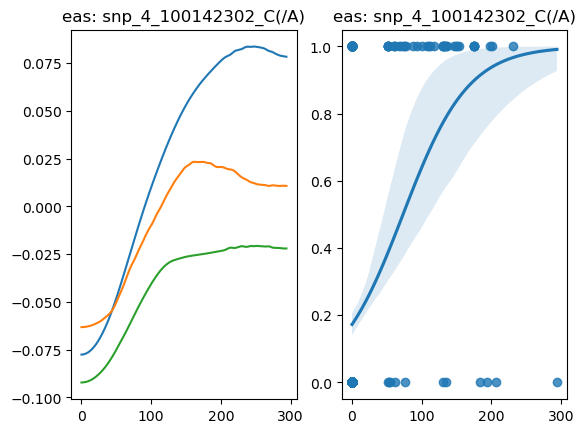

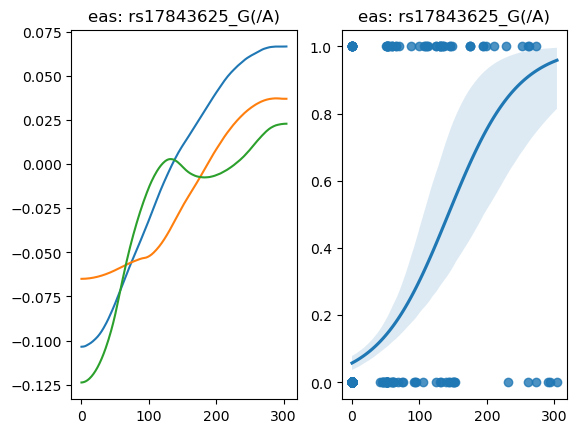

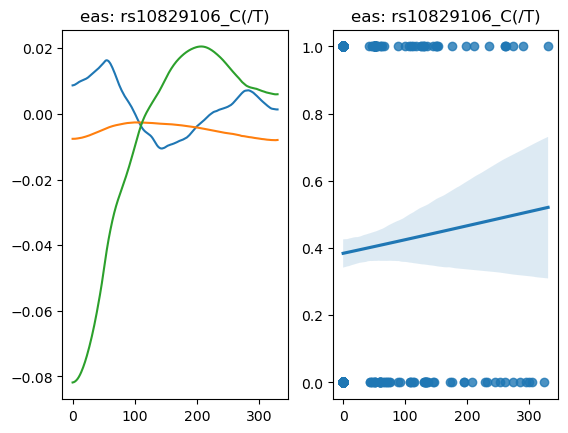

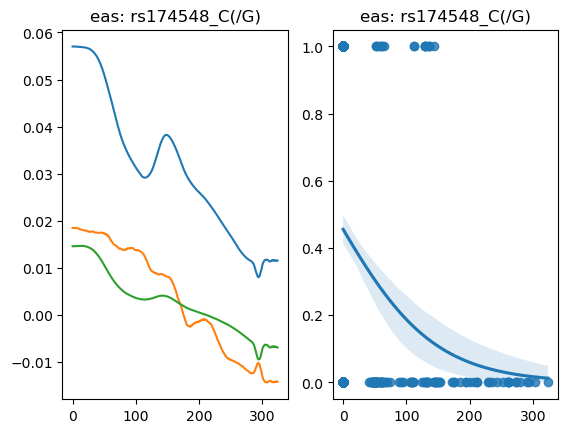

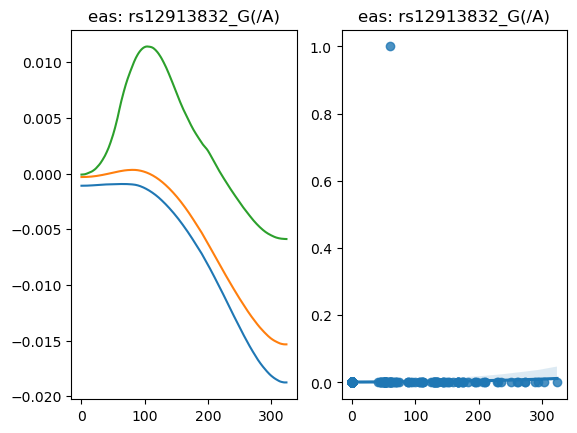

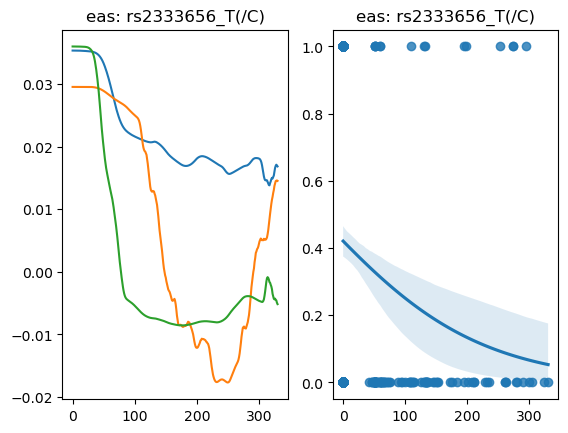

In [5]:
#Run for all EAS SNPs
pop="eas"
datasets, snps=read_data(pop)
for data,snp in zip(datasets, snps): 
    print(snp)
    try:
        s=run_analysis(data, alpha=1e4, beta=1, em_iterations=2)
        fig, axs = plt.subplots(ncols=2, nrows=1)
        axs[0].plot(s[:, 0], color="tab:blue", alpha=1)
        axs[0].plot(s[:, 1], color="tab:orange", alpha=1)
        axs[0].plot(s[:, 2], color="tab:green", alpha=1)
        a,b=[int(y) for x,y in zip(data.obs, data.t) if x[0]>0],[int(x[1]) for x,y in zip(data.obs, data.t) if x[0]>0]
        sns.regplot(x=a, y=b, logistic=True, ax=axs[1])
        axs[0].set_title(pop+": "+snp)
        axs[1].set_title(pop+": "+snp)
        print(snp)
    except:
        print("Error: "+ snp)


In [ ]:
#Run for all EUR SNPs
pop="eur"
datasets, snps=read_data(pop)
for data,snp in zip(datasets, snps): 
    print(snp)
    try:
        s=run_analysis(data, alpha=1e4
                       , beta=1, em_iterations=3)
        fig, axs = plt.subplots(ncols=2, nrows=1)
        axs[0].plot(s[:, 0], color="tab:blue", alpha=1)
        axs[0].plot(s[:, 1], color="tab:orange", alpha=1)
        axs[0].plot(s[:, 2], color="tab:green", alpha=1)
        axs[0].plot(s[:, 3], color="tab:brown", alpha=1)
        a,b=[int(y) for x,y in zip(data.obs, data.t) if x[0]>0],[int(x[1]) for x,y in zip(data.obs, data.t) if x[0]>0]
        sns.regplot(x=a, y=b, logistic=True, ax=axs[1])
        axs[0].set_title(pop+": "+snp)
        axs[1].set_title(pop+": "+snp)
    except:
        print("Error: "+ snp)


rs4988235_A(/G)


2024-09-30 10:42:27.405 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[1.0001    , 1.0001    , 1.0001    , 1.0001    ],
       [5.92632016, 7.21806179, 7.14798937, 4.83147569]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(1252.32886471, dtype=float64, weak_type=True), success=True, status=0, iter_num=12, hess_inv=LbfgsInvHessProduct(sk=[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  3.34044945e-03 4.25738853e-03 8.76245322e-03 5.79979003e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  6.76669272e-05 8.52786581e-05 1.72261064e-04 1.14941293e-04]], yk=[[-6.55296513e-05 -1.54450819e-04 -4.98634419e-04 -1.52624133e-04
   1.39642486e-05  2.91361760e-05  9.83392505e-05  5.42143546e-05]
 [-1.32987751e-06 -1.84631237e-06 -8.88382539e-06 -2.91003918e-06
   2.78385458e-07  2.54315621e-07  1.91264453e-06  1.06525578e-06]]), num_fun_eval=Array(159, dtype=int32), num_jac_eval=Array(159, dtype=int32), num_hess_eval=Array(0, dt

rs2245556_T(/C)


2024-09-30 11:15:48.543 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[1.0001    , 1.0001    , 1.0001    , 1.0001    ],
       [4.75483799, 5.49940009, 6.53380927, 4.19495767]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(1138.504912, dtype=float64, weak_type=True), success=False, status=2, iter_num=4, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(45, dtype=int32), num_jac_eval=Array(45, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-09-30 11:24:09.802 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[ 1.00356781e-02,  9.12173996e-03,  5.30168266e-05,
        -9.82403253e-03],
       [ 1.00331789e-02,  9.11175982e-03,  5.19830415e-05,
        -9.82578889e-03],
       [ 1.00288043e-02,  9.06397252e-03,  5.38794073e-05,
        -9.82781587e-03],
       ...,
       [ 6.90428175e-03,  7.49703531e-03, -6.72051275e-03,
        -3.00151071e-03],
       [ 6.88892681e-03,  7.53358809e-03, -6.72891965e-03,
 

rs160578_G(/A)


2024-09-30 11:44:30.488 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[3.27767733, 1.0001    , 1.61625264, 2.66523031],
       [1.0001    , 1.43683726, 3.04961439, 1.00028533]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(2038.11349122, dtype=float64, weak_type=True), success=True, status=0, iter_num=6, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(71, dtype=int32), num_jac_eval=Array(71, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-09-30 11:47:27.168 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[ 6.69670412e-07, -2.73647991e-07, -1.76513570e-07,
         6.69670412e-07],
       [ 6.69670412e-07, -2.73382704e-07, -1.76531224e-07,
         6.69670412e-07],
       [ 6.69670412e-07, -2.73117276e-07, -1.76548879e-07,
         6.69670412e-07],
       ...,
       [-6.69670412e-07,  6.69670412e-07, -6.69670412e-07,
        -6.69670412e-07],
       [-6.69670412e-07,  6.69670412e-07, -6.69670412e-07,


rs16891982_C(/G)


2024-09-30 11:55:47.235 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[1.0001    , 1.13502445, 1.11000195, 1.0001    ],
       [1.0001    , 1.0001    , 1.0001    , 1.22469396]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(1777.21546146, dtype=float64, weak_type=True), success=True, status=0, iter_num=5, hess_inv=LbfgsInvHessProduct(sk=[[0.00000000e+00 1.84308355e-05 5.81310134e-06 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 4.54737600e-06]], yk=[[ 2.45549858e-07  2.67662443e-06  3.30196104e-06  1.99212949e-06
  -2.97744253e-07 -8.69472505e-06 -2.38131249e-06  3.32079527e-08]]), num_fun_eval=Array(74, dtype=int32), num_jac_eval=Array(74, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-09-30 12:04:10.052 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[ 2.48298906e-02, -2.29747410e-02,  2.26503747e-05,
        -2.15887875e-02],
       [ 2.48344809e-02, -2.29746342e-02,  2.38991976e-05,
        -2.15

rs17843625_G(/A)


2024-09-17 16:13:39.037 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[ 94.01441196,   1.0001    ],
       [  4.27580512, 100.        ]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(28.23971619, dtype=float64, weak_type=True), success=True, status=0, iter_num=20, hess_inv=LbfgsInvHessProduct(sk=[[ 8.05215920e+00  0.00000000e+00  1.62844883e-01  8.71673000e+00]
 [ 1.08142519e+01  0.00000000e+00  3.77846194e-01  1.17103975e+01]
 [ 1.51638098e+01  0.00000000e+00  7.00733674e-01  1.64188673e+01]
 [ 2.25363164e+01  0.00000000e+00  1.37157526e+00  2.32426136e+01]
 [ 1.95357033e-01  0.00000000e+00  4.83106447e-01  0.00000000e+00]
 [ 1.58889211e-01  0.00000000e+00  2.23255785e-01  0.00000000e+00]
 [ 2.80122555e-02  0.00000000e+00 -4.31392363e-02  0.00000000e+00]
 [ 3.76022058e-03  0.00000000e+00 -5.09240952e-04  0.00000000e+00]
 [ 1.23162226e-04  0.00000000e+00 -8.37229677e-06  0.00000000e+00]
 [ 7.02985016e+00  0.00000000e+00  0.00000000e+00  7.60001029e+0

2024-09-17 16:16:06.671 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[94.12333811,  1.01508164],
       [ 1.503334  , 99.99970583]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(22.42049112, dtype=float64, weak_type=True), success=True, status=0, iter_num=6, hess_inv=LbfgsInvHessProduct(sk=[[ 9.22123301e-07  2.93684448e-07 -2.07786040e-05 -5.77166068e-09]], yk=[[ 7.94386346e-09 -1.30740478e-11 -1.50140924e-07  3.77231224e-13]]), num_fun_eval=Array(84, dtype=int32), num_jac_eval=Array(84, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-09-17 16:18:00.679 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[-1.40412330e-01, -6.92296154e-02],
       [-1.40314146e-01, -6.92235996e-02],
       [-1.40117697e-01, -6.92114377e-02],
       [-1.39822367e-01, -6.91927948e-02],
       [-1.39437335e-01, -6.91674230e-02],
       [-1.38962660e-01, -6.91350526e-02],
       [-1.38398612e-01, -6.90954817e-02],
       [-1.37745424e-01, -

rs199959180_A(/G)


2024-09-17 16:18:13.510 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[  8.13040077,  58.08640876],
       [100.        ,  72.7906288 ]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(139.15106661, dtype=float64, weak_type=True), success=True, status=0, iter_num=15, hess_inv=LbfgsInvHessProduct(sk=[[ 1.03913897e+00  7.98389924e+00  1.57837632e+01  1.01229020e+01]
 [ 1.64041525e+00  1.12754367e+01  2.25821734e+01  1.55986012e+01]
 [ 1.96085008e+00  1.58852015e+01  1.65640271e+01  1.77865294e+01]
 [-2.20599325e-04 -9.16926558e-04  0.00000000e+00 -7.95381463e-04]
 [ 0.00000000e+00  1.27601426e+00  2.58870608e+00  1.69968898e+00]
 [ 0.00000000e+00  1.50465022e+00  2.92123545e+00  1.94986617e+00]
 [ 1.00709998e+00  4.03449549e+00  8.11843790e+00  5.21601996e+00]
 [ 5.56503702e-01  4.28398677e+00  8.50323704e+00  5.49075734e+00]
 [ 1.02292360e+00  6.27278635e+00  1.24992801e+01  7.97101155e+00]
 [-9.64000086e-02  2.18601978e+00  4.15619194e+00  2.74752434e+

2024-09-17 16:20:24.024 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[  8.13097399,  58.08643526],
       [100.        ,  72.79078298]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(136.1493858, dtype=float64, weak_type=True), success=True, status=0, iter_num=2, hess_inv=LbfgsInvHessProduct(sk=[[5.47892790e-04 2.41224684e-05 0.00000000e+00 1.41251021e-04]], yk=[[ 1.38550353e-05 -8.35168450e-08 -1.06242609e-06  6.99824549e-08]]), num_fun_eval=Array(30, dtype=int32), num_jac_eval=Array(30, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-09-17 16:21:36.526 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[ 7.47854404e-02,  1.20775757e-02],
       [ 7.47246973e-02,  1.20728595e-02],
       [ 7.46018447e-02,  1.20633049e-02],
       [ 7.44195576e-02,  1.20490224e-02],
       [ 7.41849169e-02,  1.20300093e-02],
       [ 7.39001746e-02,  1.20065644e-02],
       [ 7.35694048e-02,  1.19786568e-02],
       [ 7.31913035e-02,  

/Users/mathi/anaconda3/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/mathi/anaconda3/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/mathi/anaconda3/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/mathi/anaconda3/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/mathi/anaconda3/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/mathi/anaconda3/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/mathi/anaconda3/lib/python3.10/site-packages/statsmodels/genmod

/Users/mathi/anaconda3/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/mathi/anaconda3/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/mathi/anaconda3/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/mathi/anaconda3/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/mathi/anaconda3/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/mathi/anaconda3/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/mathi/anaconda3/lib/python3.10/site-packages/statsmodels/genmod

rs2072786_C(/G)


2024-09-17 16:21:55.421 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[47.1060425 , 50.44635256],
       [90.63484216, 71.41576977]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(167.99070044, dtype=float64, weak_type=True), success=True, status=0, iter_num=20, hess_inv=LbfgsInvHessProduct(sk=[[-2.39908542e-01  1.18762230e-01  1.88823862e-01 -2.48422138e-04]
 [-7.30156239e-01  6.08319320e-01  8.86430791e-01  2.45858053e-01]
 [ 1.37483478e-03  2.19915705e-03  1.80741954e-03  1.77860129e-03]
 [ 5.43211075e-01  8.44784527e-01  8.72554222e-01  9.32020172e-01]
 [ 5.75074382e-03  9.02101799e-03  5.39037794e-03  1.10425150e-02]
 [ 4.01854069e-02  7.18780358e-02  5.56283298e-02  8.66472988e-02]
 [ 6.56199667e-03  9.84438399e-03  9.32521946e-03  1.40438086e-02]], yk=[[-7.42635305e-04  2.15942301e-04  3.92952694e-04 -1.52297684e-04]
 [-3.07029295e-03  6.71835364e-04  1.61106627e-03 -4.59609460e-04]
 [ 1.26464970e-06  1.60387990e-06 -5.74736853e-07 -1.05066849e

2024-09-17 16:23:56.441 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[47.10604252, 50.44635258],
       [90.63484215, 71.41576976]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(158.21734957, dtype=float64, weak_type=True), success=True, status=0, iter_num=1, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(12, dtype=int32), num_jac_eval=Array(12, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-09-17 16:25:26.943 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[-1.03450449e-01, -2.19411499e-02],
       [-1.03327649e-01, -2.19327530e-02],
       [-1.03082012e-01, -2.19159744e-02],
       [-1.02713689e-01, -2.18908490e-02],
       [-1.02219616e-01, -2.18574140e-02],
       [-1.01600390e-01, -2.18157361e-02],
       [-1.00855981e-01, -2.17658756e-02],
       [-9.99873870e-02, -2.17079326e-02],
       [-9.89941338e-02, -2.16419910e-02],
       [-9.78774362e-02, -2.15681855e-02],
       [-9.66361928e-02, -

rs6001841_G(/A)


2024-09-17 16:25:40.099 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[56.45881263, 61.30305783],
       [55.92202096, 83.61715896]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(152.38309798, dtype=float64, weak_type=True), success=True, status=0, iter_num=15, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(83, dtype=int32), num_jac_eval=Array(83, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-09-17 16:27:07.261 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[-1.09160741e-01, -1.49175262e-02],
       [-1.09029307e-01, -1.49097596e-02],
       [-1.08766638e-01, -1.48942410e-02],
       [-1.08372862e-01, -1.48709979e-02],
       [-1.07848159e-01, -1.48400680e-02],
       [-1.07192216e-01, -1.48015025e-02],
       [-1.06404698e-01, -1.47553641e-02],
       [-1.05485045e-01, -1.47017308e-02],
       [-1.04432777e-01, -1.46406917e-02],
       [-1.03247669e-01, -1.45723537e-02],
       [-1.01929667e-01, 

2024-09-17 16:27:14.390 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[60.00290351, 63.00827713],
       [50.41026958, 82.56806842]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(143.29822893, dtype=float64, weak_type=True), success=False, status=2, iter_num=4, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(75, dtype=int32), num_jac_eval=Array(75, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-09-17 16:28:13.650 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[-1.09522291e-01, -8.48519177e-03],
       [-1.09386913e-01, -8.47895557e-03],
       [-1.09116059e-01, -8.46649917e-03],
       [-1.08710178e-01, -8.44785179e-03],
       [-1.08169368e-01, -8.42305670e-03],
       [-1.07495292e-01, -8.39216909e-03],
       [-1.06688102e-01, -8.35526098e-03],
       [-1.05750157e-01, -8.31241422e-03],
       [-1.04680427e-01, -8.26372504e-03],
       [-1.03480621e-01, -8.20930141e-03],
       [-1.02148491e-01, 

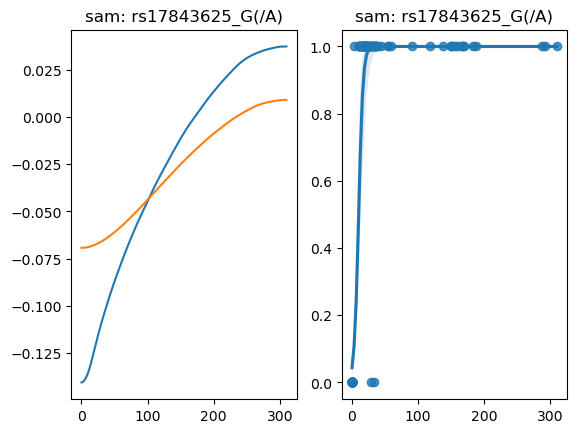

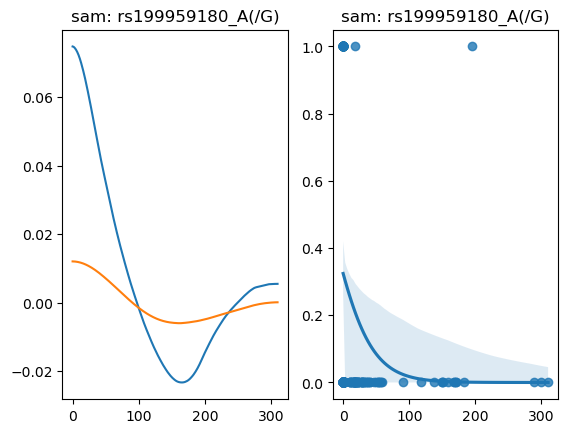

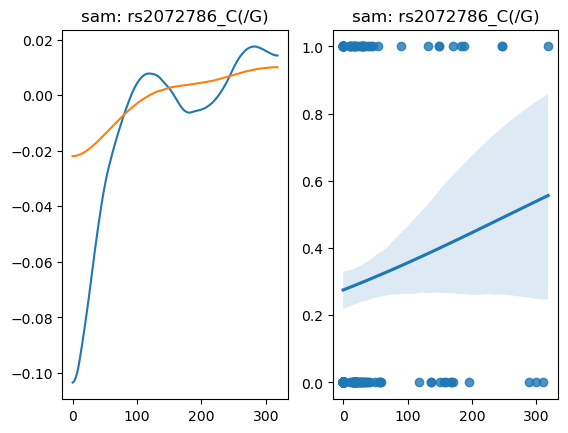

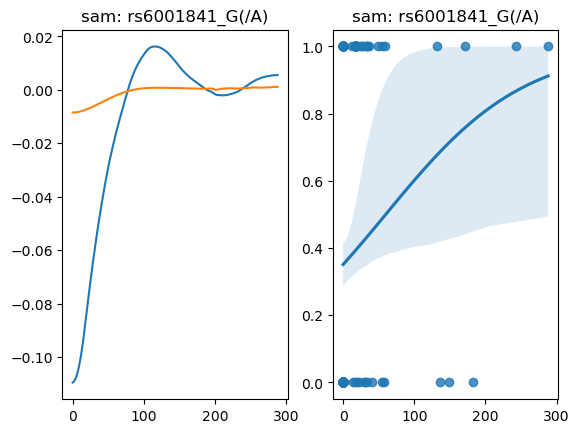

In [8]:
#Run for all SAM SNPs
pop="sam"
datasets, snps=read_data(pop)
for data,snp in zip(datasets, snps): 
    print(snp)
    try:
        s=run_analysis(data, alpha=1e4, beta=1, em_iterations=2)
        fig, axs = plt.subplots(ncols=2, nrows=1)
        axs[0].plot(s[:, 0], color="tab:blue", alpha=1)
        axs[0].plot(s[:, 1], color="tab:orange", alpha=1)
        a,b=[int(y) for x,y in zip(data.obs, data.t) if x[0]>0],[int(x[1]) for x,y in zip(data.obs, data.t) if x[0]>0]
        sns.regplot(x=a, y=b, logistic=True, ax=axs[1])
        axs[0].set_title(pop+": "+snp)
        axs[1].set_title(pop+": "+snp)
    except:
        print("Error: "+ snp)


rs4988235_A(/G)


2024-09-23 13:33:05.237 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[ 1.0001    ,  1.0001    ,  1.0001    ],
       [10.02568466,  8.97916002, 10.26402101]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(1250.67032186, dtype=float64, weak_type=True), success=True, status=0, iter_num=10, hess_inv=LbfgsInvHessProduct(sk=[[0.         0.         0.         0.04996823 0.04800083 0.01595826]
 [0.         0.         0.         0.00194319 0.00185835 0.00061793]], yk=[[-2.25887027e-03 -3.37250693e-03 -2.39275430e-03  3.59016143e-04
   4.58450354e-04  1.51040070e-04]
 [-8.71141964e-05 -6.97313529e-05 -1.14577881e-05  1.38747916e-05
   1.02721506e-05  1.20786134e-06]]), num_fun_eval=Array(89, dtype=int32), num_jac_eval=Array(89, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-09-23 13:40:27.550 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[-0.00186875, -0.02409635, -0.03509419],
       [-0.00186833, -0.02410342, -0.0350707

rs2245556_T(/C)


2024-09-23 13:56:49.243 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[1.0001    , 1.0001    , 1.0001    ],
       [1.16625593, 1.14384748, 1.08375422]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(1147.280997, dtype=float64, weak_type=True), success=True, status=0, iter_num=5, hess_inv=LbfgsInvHessProduct(sk=[[0.00000000e+00 0.00000000e+00 0.00000000e+00 3.49014206e-05
  2.97972867e-05 1.69245527e-05]], yk=[[-1.47688777e-05 -9.74149705e-06  4.04532601e-07  1.99914113e-05
   1.38718352e-05 -1.33150581e-06]]), num_fun_eval=Array(82, dtype=int32), num_jac_eval=Array(82, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-09-23 14:02:07.702 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[ 0.03791889, -0.00513596,  0.05698072],
       [ 0.03789108, -0.00517035,  0.0569919 ],
       [ 0.0378368 , -0.00523904,  0.05700292],
       ...,
       [-0.0718688 , -0.08321691, -0.07140686],
       [-0.07170928, -0.0833264 , -0.0714

rs160578_G(/A)


2024-09-23 14:17:29.299 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[4.5119894 , 5.84781079, 3.88123154],
       [6.61833422, 4.93783273, 3.78844557]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(2045.43719922, dtype=float64, weak_type=True), success=True, status=0, iter_num=9, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(79, dtype=int32), num_jac_eval=Array(79, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-09-23 14:21:44.427 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[-0.00292811,  0.00306622, -0.00497697],
       [-0.0029337 ,  0.00296358, -0.00505685],
       [-0.00294751,  0.00275165, -0.00522595],
       ...,
       [ 0.0276745 ,  0.00346621,  0.01940815],
       [ 0.0268521 ,  0.00295414,  0.01874783],
       [ 0.02531779,  0.0016555 ,  0.01728166]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(2010.3401217, dtype=float64, weak_type=True), success=True, status=0, iter_num=2

rs16891982_C(/G)


2024-09-23 14:42:05.438 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[63.45381099, 28.25824711,  3.25084344],
       [ 1.00113271, 22.50298069,  4.00790304]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(1779.09493491, dtype=float64, weak_type=True), success=True, status=0, iter_num=12, hess_inv=LbfgsInvHessProduct(sk=[[ 2.44660603e-03  2.06255375e-03 -1.50677338e-04  2.22645242e-04
   1.34004236e-03 -1.05189812e-04]
 [ 5.42201191e-01  2.03905105e-01  0.00000000e+00  0.00000000e+00
   1.56562993e-01 -7.48788180e-02]
 [ 6.44964767e-01  2.44587966e-01  0.00000000e+00  0.00000000e+00
   2.08747105e-01 -3.62154144e-02]
 [ 1.27379227e-04  4.66591438e-05  0.00000000e+00  0.00000000e+00
   4.15335502e-05  9.53780580e-06]
 [ 2.59040517e+00  1.12493217e+00  0.00000000e+00  0.00000000e+00
   8.84208037e-01  2.33350925e-01]
 [ 1.09809402e+01  4.76811811e+00  7.68322775e-01  0.00000000e+00
   3.84521650e+00  6.18945633e-01]
 [ 4.82914608e-01  2.09611533e-01  3.

rs3091338_T(/C)


2024-09-23 15:20:24.583 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[  1.0001    ,  15.41274994,   1.0001    ],
       [100.        , 100.        , 100.        ]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(1933.61776651, dtype=float64, weak_type=True), success=True, status=0, iter_num=14, hess_inv=LbfgsInvHessProduct(sk=[[ 0.00000000e+00  1.11161830e-02  0.00000000e+00  9.64541433e-02
   7.98397481e-02  8.20605059e-02]
 [ 0.00000000e+00  8.60298389e+00  0.00000000e+00  4.29149090e+01
   5.23473476e+01  5.08382720e+01]
 [ 0.00000000e+00 -5.48040630e-04  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  6.90393708e-03
   5.61236297e-03  5.76955624e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  4.07912766e+00
   3.29021683e+00  3.36764469e+00]
 [ 0.00000000e+00  6.17684879e-02  0.00000000e+00  2.15477971e+00
   1.74264663e+00  1.78983973e+00]
 [ 0.00000000e+00  1.05412955e-

rs6555913_G(/A)


2024-09-23 15:44:05.697 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[34.09660098, 33.25578564, 26.57640674],
       [46.73942269, 46.35452465, 14.93423538]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(2233.07519671, dtype=float64, weak_type=True), success=True, status=0, iter_num=16, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(65, dtype=int32), num_jac_eval=Array(65, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-09-23 15:47:27.750 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[-0.01914506, -0.02254085, -0.023522  ],
       [-0.01912618, -0.02249261, -0.02341227],
       [-0.01908862, -0.0223928 , -0.0232012 ],
       ...,
       [-0.01154873,  0.00458983,  0.01368669],
       [-0.01165255,  0.00477967,  0.01381224],
       [-0.01173188,  0.00506082,  0.01391529]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(2207.38023382, dtype=float64, weak_type=True), success=True, status=0, it

rs17843625_G(/A)


2024-09-23 16:10:35.470 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[2.73754231, 1.00022057, 1.0001    ],
       [1.0001    , 1.86270422, 1.82923381]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(1533.20800133, dtype=float64, weak_type=True), success=False, status=2, iter_num=3, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(50, dtype=int32), num_jac_eval=Array(50, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-09-23 16:17:55.900 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[-0.029534  , -0.13749322, -0.15101615],
       [-0.02954277, -0.13741384, -0.1508752 ],
       [-0.02955566, -0.13725623, -0.15059186],
       ...,
       [ 0.02470513, -0.03130827, -0.01212463],
       [ 0.0242066 , -0.03096587, -0.01144883],
       [ 0.02401118, -0.03082797, -0.01135562]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(1487.06970414, dtype=float64, weak_type=True), success=True, status=0, iter_num

rs174548_G(/C)


2024-09-23 16:39:21.017 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[100.        ,  65.11260718,  18.30652198],
       [  9.54302083,  38.00878106,  89.54874405]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(2403.13211202, dtype=float64, weak_type=True), success=False, status=2, iter_num=20, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(79, dtype=int32), num_jac_eval=Array(79, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-09-23 16:49:03.834 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[-0.0226763 , -0.04326483,  0.00827635],
       [-0.02280398, -0.04324166,  0.00831643],
       [-0.02295306, -0.04320844,  0.00837758],
       ...,
       [ 0.04619599,  0.02100937,  0.03712934],
       [ 0.04656601,  0.02111018,  0.03710346],
       [ 0.04676388,  0.02119343,  0.03710108]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(2357.59733911, dtype=float64, weak_type=True), success=True, statu

rs12913832_A(/G)


2024-09-23 17:09:27.665 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[39.9015317 , 65.42404322,  2.13858866],
       [48.76028921, 12.92903613,  1.02181184]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(2144.92361135, dtype=float64, weak_type=True), success=False, status=2, iter_num=18, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(161, dtype=int32), num_jac_eval=Array(161, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-09-23 17:20:20.390 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[-2.20439013e-02,  4.46647504e-02, -3.13758189e-02],
       [-2.20422858e-02,  4.47590147e-02, -3.13994819e-02],
       [-2.20397443e-02,  4.49270586e-02, -3.14533753e-02],
       ...,
       [ 1.19142994e-02,  9.20507948e-04, -3.59074370e-02],
       [ 1.15319471e-02,  5.01563813e-04, -3.62988279e-02],
       [ 1.07929654e-02, -5.61553701e-05, -3.68468419e-02]],      dtype=float64), state=ScipyMinimizeInfo(fun_val

rs1426654_G(/A)


2024-09-23 17:55:32.647 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[  1.0001,   1.0001,   1.0001],
       [  1.0001, 100.    ,   1.0001]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(225.60008864, dtype=float64, weak_type=True), success=True, status=0, iter_num=11, hess_inv=LbfgsInvHessProduct(sk=[[ 0.          0.          0.          0.          0.74677289  0.        ]
 [ 0.          0.          0.          0.          0.96742275  0.        ]
 [ 0.          0.          0.          0.          1.40390547  0.        ]
 [ 0.          0.          0.          0.          2.22667873  0.        ]
 [ 0.          0.          0.          0.          3.47295745  0.        ]
 [ 0.          0.          0.          0.          5.48950314  0.        ]
 [ 0.          0.          0.          0.          7.45488395  0.        ]
 [ 0.          0.          0.          0.         12.11381328  0.        ]
 [ 0.          0.          0.          0.         15.29476063 

2024-09-23 18:02:37.346 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[  1.00011143,   1.0001    ,   1.0001    ],
       [  1.0001    , 100.        ,   1.00014116]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(182.45698554, dtype=float64, weak_type=True), success=False, status=2, iter_num=2, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(55, dtype=int32), num_jac_eval=Array(55, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-09-23 18:12:09.905 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[ 1.17955229e-02,  6.83828885e-03,  9.97571979e-03],
       [ 1.18184773e-02,  6.94162054e-03,  9.97667723e-03],
       [ 1.18649872e-02,  7.14781340e-03,  9.98486968e-03],
       [ 1.19370719e-02,  7.44442747e-03,  9.99209210e-03],
       [ 1.20356477e-02,  7.82669591e-03,  1.00247133e-02],
       [ 1.21613376e-02,  8.28824745e-03,  1.00476141e-02],
       [ 1.23127043e-02,  8.83607189e-03,  1.01076528e-02],
   

2024-09-23 18:13:38.629 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[ 1.46331395,  1.00552417,  1.08582027],
       [ 1.0001    , 99.99995815,  1.11283411]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(183.26931679, dtype=float64, weak_type=True), success=True, status=0, iter_num=12, hess_inv=LbfgsInvHessProduct(sk=[[ 1.08038088e-05  1.63958469e-07 -4.71599043e-06  0.00000000e+00
  -1.66520177e-09  5.49860419e-06]], yk=[[ 5.53800502e-06 -3.46569282e-09 -4.54160283e-06 -1.55706452e-06
   5.85692137e-11  6.35551691e-06]]), num_fun_eval=Array(117, dtype=int32), num_jac_eval=Array(117, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-09-23 18:21:01.934 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[ 4.97396576e-03,  5.06274621e-03,  3.36851362e-03],
       [ 4.98749221e-03,  5.03883308e-03,  3.46789383e-03],
       [ 5.01387411e-03,  4.99998650e-03,  3.65924133e-03],
       [ 5.05262412e-03,  4.95621213e-03,  3.9311

rs7225592_A(/G)


2024-09-23 18:21:38.107 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[ 35.58184756,   1.0001    ,   1.0001    ],
       [ 62.36642084, 100.        ,   1.0001    ]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(396.21469297, dtype=float64, weak_type=True), success=False, status=2, iter_num=14, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(80, dtype=int32), num_jac_eval=Array(80, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-09-23 18:26:00.683 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[ 0.07108946,  0.09910853,  0.14540874],
       [ 0.07108798,  0.09907032,  0.14538067],
       [ 0.07108478,  0.09899432,  0.14532078],
       [ 0.07107931,  0.09888172,  0.14522045],
       [ 0.07107173,  0.09873408,  0.14507275],
       [ 0.07106113,  0.09855626,  0.14486826],
       [ 0.07104933,  0.09835514,  0.14460282],
       [ 0.07103485,  0.09814573,  0.14426758],
       [ 0.07102143,  0.097945  ,  0.1

2024-09-23 18:26:20.972 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[ 35.58177489,   1.0001    ,   1.00027667],
       [ 62.3664478 , 100.        ,   1.0001    ]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(361.70346415, dtype=float64, weak_type=True), success=True, status=0, iter_num=3, hess_inv=LbfgsInvHessProduct(sk=[[-1.25322615e-06  0.00000000e+00  2.88347324e-06  4.64909287e-07
   0.00000000e+00  0.00000000e+00]], yk=[[ 7.56030938e-09  8.73836288e-10  4.76334206e-06 -3.83453715e-09
  -2.46019584e-11 -3.40129803e-06]]), num_fun_eval=Array(62, dtype=int32), num_jac_eval=Array(62, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-09-23 18:29:02.973 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[ 6.90645288e-02,  9.82245958e-02,  1.64511935e-01],
       [ 6.90606090e-02,  9.81935987e-02,  1.64368530e-01],
       [ 6.90511349e-02,  9.81332122e-02,  1.64084493e-01],
       [ 6.90407439e-02,  9.80546729e-02,  1.6

2024-09-23 18:29:20.654 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[ 35.58175944,   1.0001    ,   1.00030956],
       [ 62.36645347, 100.        ,   1.0001    ]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(357.72944172, dtype=float64, weak_type=True), success=False, status=2, iter_num=1, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(54, dtype=int32), num_jac_eval=Array(54, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-09-23 18:30:38.613 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[ 0.08135636,  0.09160822,  0.11966192],
       [ 0.08135631,  0.09160862,  0.11965903],
       [ 0.08135641,  0.09160129,  0.11962208],
       [ 0.08135637,  0.09158383,  0.11957477],
       [ 0.08135662,  0.09154445,  0.11945654],
       [ 0.08135443,  0.09148188,  0.11930665],
       [ 0.0813456 ,  0.09140005,  0.11904194],
       [ 0.08135667,  0.09128095,  0.11872021],
       [ 0.08132621,  0.09114859,  0.11

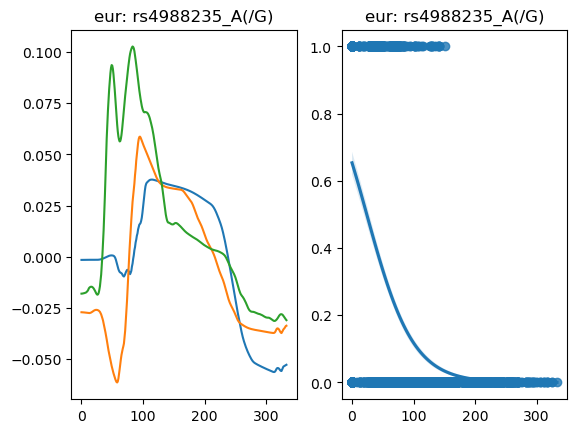

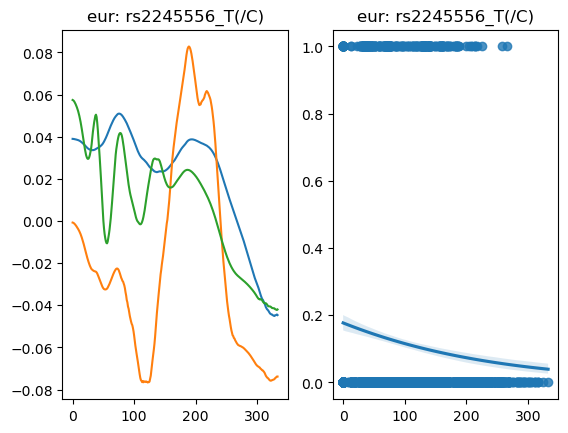

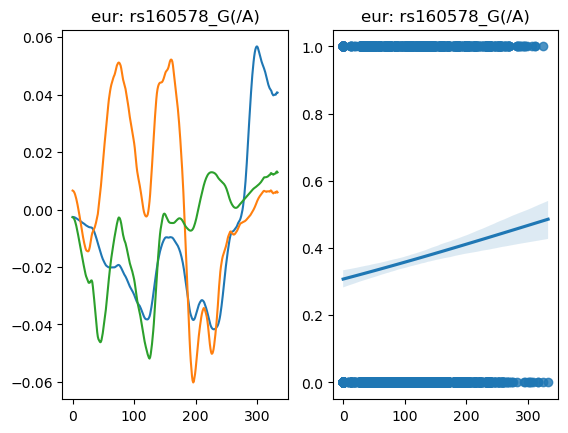

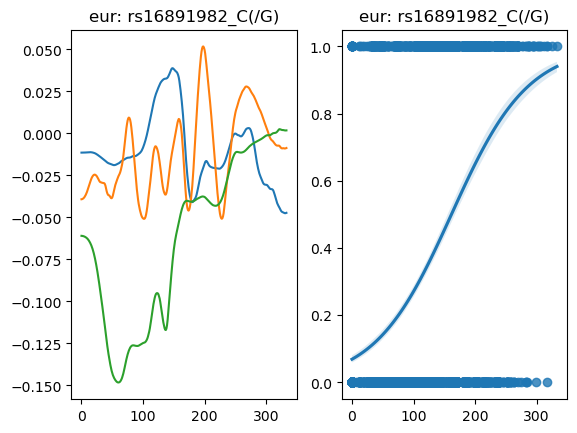

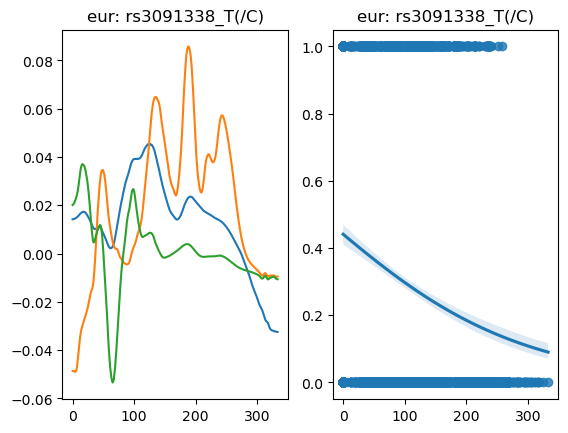

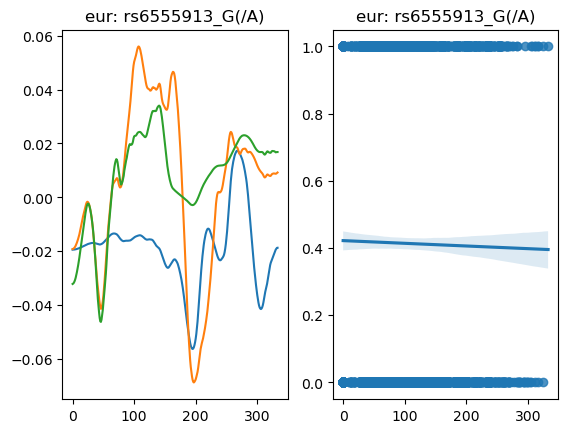

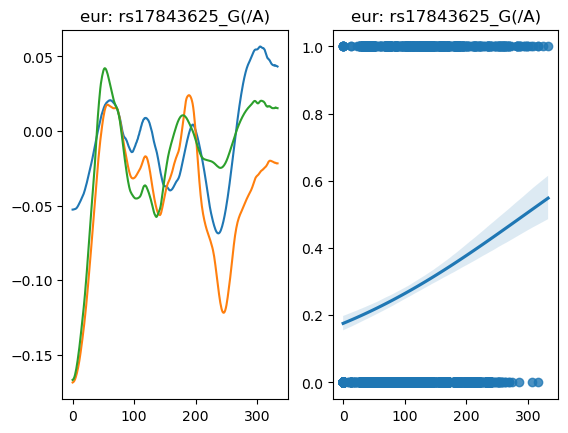

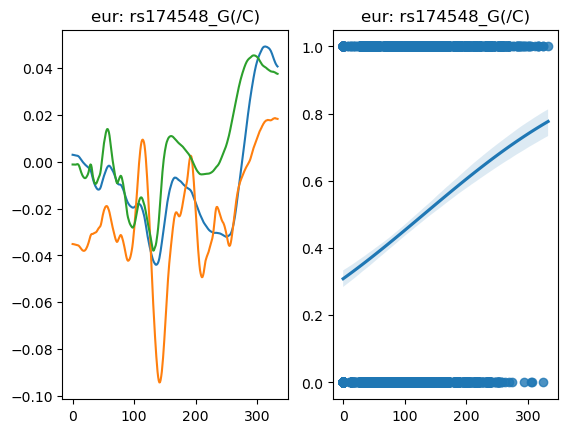

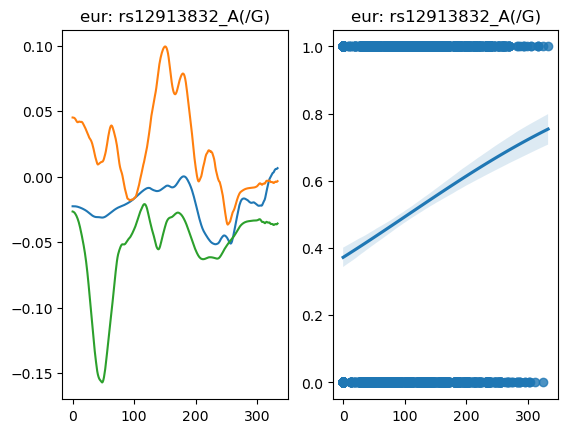

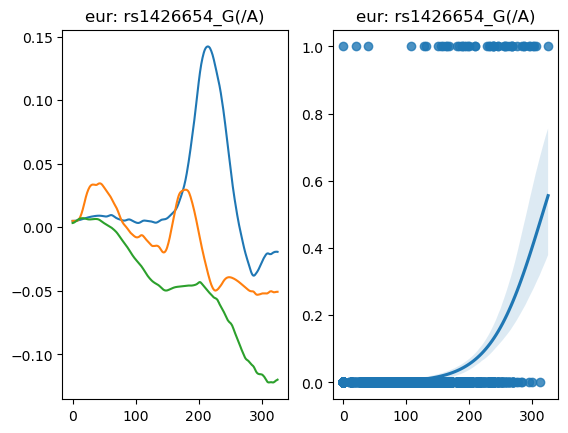

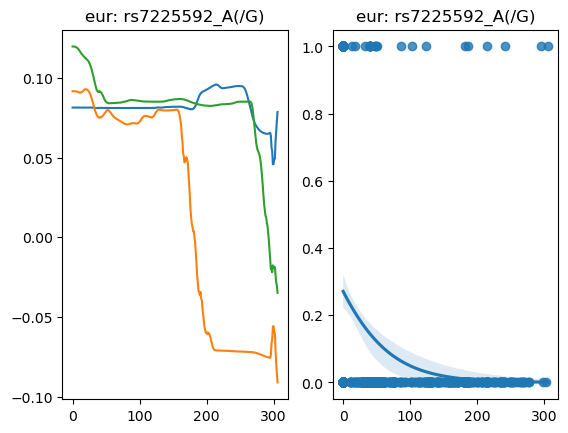

In [5]:
#Run for all EUR SNPs with k=3
pop="eur"
datasets, snps=read_data(pop, "_k3")
for data,snp in zip(datasets, snps): 
    print(snp)
    try:
        s=run_analysis(data, alpha=1e3
                       , beta=1, em_iterations=3)
        fig, axs = plt.subplots(ncols=2, nrows=1)
        axs[0].plot(s[:, 0], color="tab:blue", alpha=1)
        axs[0].plot(s[:, 1], color="tab:orange", alpha=1)
        axs[0].plot(s[:, 2], color="tab:green", alpha=1)
        a,b=[int(y) for x,y in zip(data.obs, data.t) if x[0]>0],[int(x[1]) for x,y in zip(data.obs, data.t) if x[0]>0]
        sns.regplot(x=a, y=b, logistic=True, ax=axs[1])
        axs[0].set_title(pop+": "+snp)
        axs[1].set_title(pop+": "+snp)
    except:
        print("Error: "+ snp)


rs4988235_A(/G)


2024-09-24 10:22:41.508 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[ 1.0001    ,  1.0001    ,  1.0001    ],
       [10.02568466,  8.97916002, 10.26402101]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(1250.67032186, dtype=float64, weak_type=True), success=True, status=0, iter_num=10, hess_inv=LbfgsInvHessProduct(sk=[[0.         0.         0.         0.04996823 0.04800083 0.01595826]
 [0.         0.         0.         0.00194319 0.00185835 0.00061793]], yk=[[-2.25887027e-03 -3.37250693e-03 -2.39275430e-03  3.59016143e-04
   4.58450354e-04  1.51040070e-04]
 [-8.71141964e-05 -6.97313529e-05 -1.14577881e-05  1.38747916e-05
   1.02721506e-05  1.20786134e-06]]), num_fun_eval=Array(89, dtype=int32), num_jac_eval=Array(89, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-09-24 10:36:47.867 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[ 0.00111001, -0.02590431, -0.01351984],
       [ 0.00109235, -0.02594922, -0.0134502

rs2245556_T(/C)


2024-09-24 10:49:26.749 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[1.0001    , 1.0001    , 1.0001    ],
       [1.16625593, 1.14384748, 1.08375422]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(1147.280997, dtype=float64, weak_type=True), success=True, status=0, iter_num=5, hess_inv=LbfgsInvHessProduct(sk=[[0.00000000e+00 0.00000000e+00 0.00000000e+00 3.49014206e-05
  2.97972867e-05 1.69245527e-05]], yk=[[-1.47688777e-05 -9.74149705e-06  4.04532601e-07  1.99914113e-05
   1.38718352e-05 -1.33150581e-06]]), num_fun_eval=Array(82, dtype=int32), num_jac_eval=Array(82, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-09-24 10:49:59.705 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[ 3.19454036e-15,  3.19454036e-15,  3.19454036e-15],
       [ 3.19454036e-15,  3.19454036e-15,  3.19454036e-15],
       [ 3.19454036e-15,  3.19454036e-15,  3.19454036e-15],
       ...,
       [ 3.19454036e-15, -3.19454036e-15, -3.19454036

rs160578_G(/A)


2024-09-24 11:14:48.205 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[4.5119894 , 5.84781079, 3.88123154],
       [6.61833422, 4.93783273, 3.78844557]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(2045.43719922, dtype=float64, weak_type=True), success=True, status=0, iter_num=9, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(79, dtype=int32), num_jac_eval=Array(79, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-09-24 11:25:34.048 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[-8.31142350e-03, -5.06649518e-03, -1.65857505e-02],
       [-8.32003819e-03, -5.06168706e-03, -1.65868217e-02],
       [-8.33876411e-03, -5.05223606e-03, -1.65895608e-02],
       ...,
       [ 2.78973482e-02, -1.65482404e-07,  1.87985057e-02],
       [ 2.79134827e-02,  6.00776358e-06,  1.88015684e-02],
       [ 2.79024575e-02, -1.97722374e-05,  1.87737121e-02]],      dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(201

rs16891982_C(/G)


2024-09-24 11:43:11.766 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[63.45381099, 28.25824711,  3.25084344],
       [ 1.00113271, 22.50298069,  4.00790304]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(1779.09493491, dtype=float64, weak_type=True), success=True, status=0, iter_num=12, hess_inv=LbfgsInvHessProduct(sk=[[ 2.44660603e-03  2.06255375e-03 -1.50677338e-04  2.22645242e-04
   1.34004236e-03 -1.05189812e-04]
 [ 5.42201191e-01  2.03905105e-01  0.00000000e+00  0.00000000e+00
   1.56562993e-01 -7.48788180e-02]
 [ 6.44964767e-01  2.44587966e-01  0.00000000e+00  0.00000000e+00
   2.08747105e-01 -3.62154144e-02]
 [ 1.27379227e-04  4.66591438e-05  0.00000000e+00  0.00000000e+00
   4.15335502e-05  9.53780580e-06]
 [ 2.59040517e+00  1.12493217e+00  0.00000000e+00  0.00000000e+00
   8.84208037e-01  2.33350925e-01]
 [ 1.09809402e+01  4.76811811e+00  7.68322775e-01  0.00000000e+00
   3.84521650e+00  6.18945633e-01]
 [ 4.82914608e-01  2.09611533e-01  3.

rs3091338_T(/C)


2024-09-24 12:25:21.411 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[  1.0001    ,  15.41274994,   1.0001    ],
       [100.        , 100.        , 100.        ]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(1933.61776651, dtype=float64, weak_type=True), success=True, status=0, iter_num=14, hess_inv=LbfgsInvHessProduct(sk=[[ 0.00000000e+00  1.11161830e-02  0.00000000e+00  9.64541433e-02
   7.98397481e-02  8.20605059e-02]
 [ 0.00000000e+00  8.60298389e+00  0.00000000e+00  4.29149090e+01
   5.23473476e+01  5.08382720e+01]
 [ 0.00000000e+00 -5.48040630e-04  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  6.90393708e-03
   5.61236297e-03  5.76955624e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  4.07912766e+00
   3.29021683e+00  3.36764469e+00]
 [ 0.00000000e+00  6.17684879e-02  0.00000000e+00  2.15477971e+00
   1.74264663e+00  1.78983973e+00]
 [ 0.00000000e+00  1.05412955e-

2024-09-24 12:56:19.542 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[-0.00186964, -0.02123554,  0.00909281],
       [-0.00186711, -0.02106098,  0.00916407],
       [-0.00187701, -0.02085297,  0.00915701],
       ...,
       [-0.00868719,  0.01697581,  0.01352424],
       [-0.00870539,  0.01699594,  0.01355281],
       [-0.00866639,  0.01695665,  0.01351581]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(1894.23821814, dtype=float64, weak_type=True), success=True, status=0, iter_num=54, hess_inv=LbfgsInvHessProduct(sk=[[-2.26103295e-06 -1.90584401e-06  1.32447697e-05 ...  8.59434553e-06
  -7.35837744e-06 -1.07669202e-05]
 [-6.48988885e-08  2.44717459e-08  3.71142736e-07 ...  2.01639469e-07
  -2.12869725e-07 -3.02994606e-07]
 [-3.63673735e-09 -8.04909700e-10  1.74075932e-08 ...  1.08003704e-08
  -1.12319656e-08 -1.62015701e-08]
 ...
 [-2.49375037e-05  6.81711916e-04  4.01049554e-04 ... -3.57270429e-04
  -1.89740200e-04 -1.62409101e-04]
 [-2.01729155

rs6555913_G(/A)


2024-09-24 12:57:30.497 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[34.09660098, 33.25578564, 26.57640674],
       [46.73942269, 46.35452465, 14.93423538]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(2233.07519671, dtype=float64, weak_type=True), success=True, status=0, iter_num=16, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(65, dtype=int32), num_jac_eval=Array(65, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-09-24 13:01:21.540 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[-0.01532763, -0.01506816, -0.01447404],
       [-0.01532456, -0.01505151, -0.01444341],
       [-0.01531824, -0.0150186 , -0.0143818 ],
       ...,
       [-0.01545223, -0.00065265,  0.01389981],
       [-0.0154538 , -0.00072301,  0.01392767],
       [-0.01544469, -0.00076304,  0.01392831]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(2211.46857061, dtype=float64, weak_type=True), success=True, status=0, it

rs17843625_G(/A)


2024-09-24 13:10:31.076 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[2.73754231, 1.00022057, 1.0001    ],
       [1.0001    , 1.86270422, 1.82923381]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(1533.20800133, dtype=float64, weak_type=True), success=False, status=2, iter_num=3, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(50, dtype=int32), num_jac_eval=Array(50, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-09-24 13:18:09.472 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[-0.00125014, -0.08268952, -0.09489619],
       [-0.00122094, -0.08263141, -0.09476594],
       [-0.00118625, -0.08251538, -0.09450766],
       ...,
       [ 0.01700172, -0.049189  , -0.00869503],
       [ 0.01703537, -0.04921356, -0.00874829],
       [ 0.01705806, -0.04925818, -0.00881773]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(1497.43800259, dtype=float64, weak_type=True), success=False, status=2, iter_nu

rs174548_G(/C)


2024-09-24 13:40:11.920 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[100.        ,  65.11260718,  18.30652198],
       [  9.54302083,  38.00878106,  89.54874405]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(2403.13211202, dtype=float64, weak_type=True), success=False, status=2, iter_num=20, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(79, dtype=int32), num_jac_eval=Array(79, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-09-24 13:46:32.862 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[-0.00585784, -0.03100728,  0.0044428 ],
       [-0.00585377, -0.03099761,  0.0044534 ],
       [-0.00581719, -0.03097705,  0.00447742],
       ...,
       [ 0.02800467,  0.01136991, -0.00809927],
       [ 0.02783787,  0.01125396, -0.00824051],
       [ 0.02789099,  0.01129285, -0.00814147]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(2364.02723511, dtype=float64, weak_type=True), success=True, statu

rs12913832_A(/G)


2024-09-24 14:12:44.254 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[39.9015317 , 65.42404322,  2.13858866],
       [48.76028921, 12.92903613,  1.02181184]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(2144.92361135, dtype=float64, weak_type=True), success=False, status=2, iter_num=18, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(161, dtype=int32), num_jac_eval=Array(161, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-09-24 14:27:19.784 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[-0.029709  ,  0.0315439 , -0.04760705],
       [-0.0297139 ,  0.03152149, -0.04767444],
       [-0.02972443,  0.03147681, -0.0478072 ],
       ...,
       [-0.01332034, -0.01295248, -0.04082421],
       [-0.01330711, -0.01293522, -0.04080382],
       [-0.01328847, -0.01292742, -0.04078815]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(2067.17338311, dtype=float64, weak_type=True), success=True, status=0,

rs1426654_G(/A)


2024-09-24 14:52:18.941 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[  1.0001,   1.0001,   1.0001],
       [  1.0001, 100.    ,   1.0001]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(225.60008864, dtype=float64, weak_type=True), success=True, status=0, iter_num=11, hess_inv=LbfgsInvHessProduct(sk=[[ 0.          0.          0.          0.          0.74677289  0.        ]
 [ 0.          0.          0.          0.          0.96742275  0.        ]
 [ 0.          0.          0.          0.          1.40390547  0.        ]
 [ 0.          0.          0.          0.          2.22667873  0.        ]
 [ 0.          0.          0.          0.          3.47295745  0.        ]
 [ 0.          0.          0.          0.          5.48950314  0.        ]
 [ 0.          0.          0.          0.          7.45488395  0.        ]
 [ 0.          0.          0.          0.         12.11381328  0.        ]
 [ 0.          0.          0.          0.         15.29476063 

2024-09-24 15:00:06.322 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[  1.0001,   1.0001,   1.0001],
       [  1.0001, 100.    , 100.    ]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(190.32367769, dtype=float64, weak_type=True), success=True, status=0, iter_num=16, hess_inv=LbfgsInvHessProduct(sk=[[ 0.          0.          0.          0.          0.          9.23919145]
 [ 0.          0.          0.          0.          0.         12.32741732]
 [ 0.          0.          0.          0.          0.         17.67529994]
 [ 0.          0.          0.          0.          0.         18.62298496]
 [ 0.          0.          0.          0.          0.          1.84035356]
 [ 0.          0.          0.          0.          0.          2.44737652]
 [ 0.          0.          0.          0.          0.          3.23398366]
 [ 0.          0.          0.          0.          0.          4.97602108]
 [ 0.          0.          0.          0.          0.         

2024-09-24 15:08:19.758 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[  1.0001,   1.0001,   1.0001],
       [  1.0001, 100.    , 100.    ]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(187.97171698, dtype=float64, weak_type=True), success=False, status=2, iter_num=0, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(21, dtype=int32), num_jac_eval=Array(21, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-09-24 15:16:31.389 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[ 1.26068121e-03,  2.16548980e-02,  1.29403856e-04],
       [ 1.26138690e-03,  2.16493297e-02,  1.35139936e-04],
       [ 1.26385271e-03,  2.16414997e-02,  1.13606769e-04],
       [ 1.26556842e-03,  2.16345017e-02,  1.25930183e-04],
       [ 1.26860203e-03,  2.16430456e-02,  1.03365493e-04],
       [ 1.27157868e-03,  2.16274402e-02,  1.11330552e-04],
       [ 1.27534394e-03,  2.16430327e-02,  9.27572057e-05],
       [ 1.28034987e-03,  2

rs7225592_A(/G)


2024-09-24 15:17:07.426 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[ 35.58184756,   1.0001    ,   1.0001    ],
       [ 62.36642084, 100.        ,   1.0001    ]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(396.21469297, dtype=float64, weak_type=True), success=False, status=2, iter_num=14, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(80, dtype=int32), num_jac_eval=Array(80, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-09-24 15:21:20.860 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[ 9.50644304e-02,  6.59172711e-02,  1.42032833e-01],
       [ 9.50400667e-02,  6.58983432e-02,  1.42013173e-01],
       [ 9.49936038e-02,  6.58602259e-02,  1.41990172e-01],
       [ 9.49183487e-02,  6.58000955e-02,  1.41932468e-01],
       [ 9.48187986e-02,  6.57171657e-02,  1.41870261e-01],
       [ 9.46858907e-02,  6.56078987e-02,  1.41768491e-01],
       [ 9.45211269e-02,  6.54712176e-02,  1.41637520e-01],
  

2024-09-24 15:21:41.100 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[ 35.48985443,   1.0001    ,   1.54386961],
       [ 62.42434527, 100.        ,   1.0001    ]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(349.94210434, dtype=float64, weak_type=True), success=True, status=0, iter_num=6, hess_inv=LbfgsInvHessProduct(sk=[[-1.26725483e-03  0.00000000e+00  4.06119633e-01  1.32590096e-03
   0.00000000e+00  0.00000000e+00]
 [-3.82738236e-03  0.00000000e+00  6.34356555e-02  2.46122572e-03
   0.00000000e+00  0.00000000e+00]
 [-7.40459776e-02  0.00000000e+00  8.48171726e-02  4.61815563e-02
   0.00000000e+00  0.00000000e+00]
 [-1.24993808e-02  0.00000000e+00 -1.03696802e-02  7.73701068e-03
   0.00000000e+00  0.00000000e+00]
 [-3.49811964e-04  0.00000000e+00 -2.31715830e-04  2.16671821e-04
   0.00000000e+00  0.00000000e+00]], yk=[[ 7.28888574e-03  1.21712402e-03  3.51372963e-01 -4.06066726e-03
  -2.28440386e-05  5.07472887e-01]
 [ 7.59924760e-04  2.3944657

2024-09-24 15:26:03.072 | DEBUG    | bmws.estimate:run_eb:117 - eb result: OptStep(params=Array([[ 35.48933706,   1.0001    ,   1.54636922],
       [ 62.42467503, 100.        ,   1.0001    ]], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(349.16566241, dtype=float64, weak_type=True), success=True, status=0, iter_num=3, hess_inv=LbfgsInvHessProduct(sk=[[-1.36301077e-04  0.00000000e+00  4.41118058e-04  8.63149246e-05
   0.00000000e+00  0.00000000e+00]], yk=[[ 4.49359323e-07  2.62315525e-07  2.09150826e-05 -2.51074777e-07
  -4.77797308e-09 -5.10688218e-05]]), num_fun_eval=Array(63, dtype=int32), num_jac_eval=Array(63, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
2024-09-24 15:29:56.013 | DEBUG    | bmws.estimate:run_ll:135 - MLE result: OptStep(params=Array([[ 7.59743871e-02,  3.43439086e-02,  9.85680438e-02],
       [ 7.59527728e-02,  3.43361139e-02,  9.85264827e-02],
       [ 7.59211301e-02,  3.43225569e-02,  9.84546979e-02],
       [ 7.58607637e-02,  3.42989511e-02,  9.8

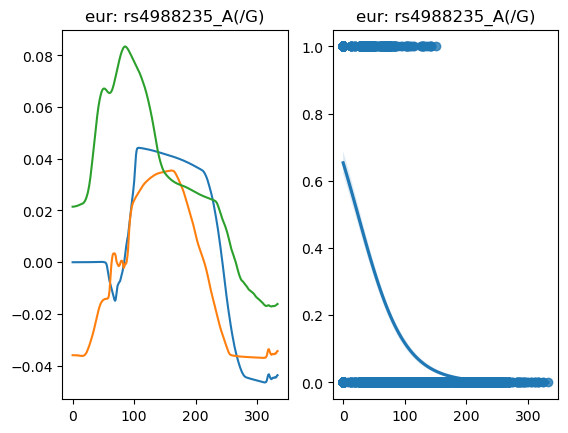

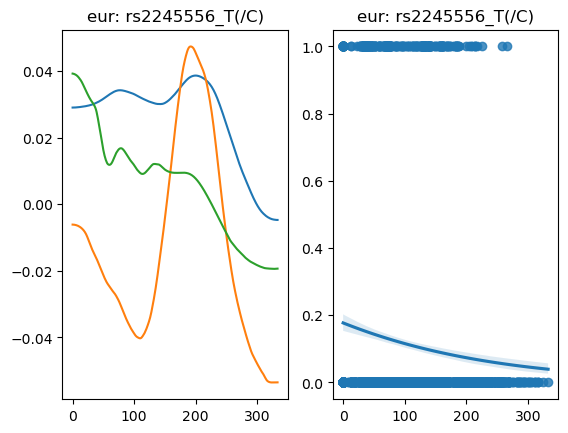

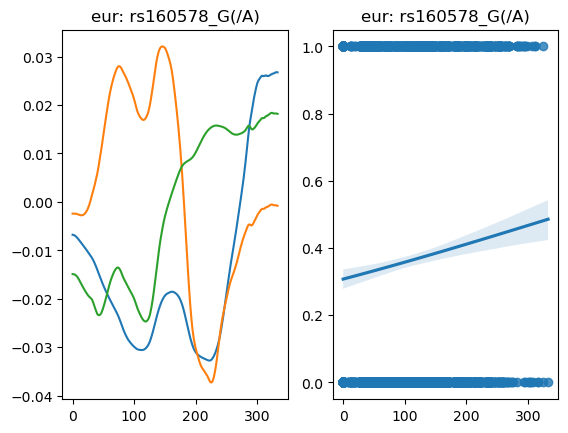

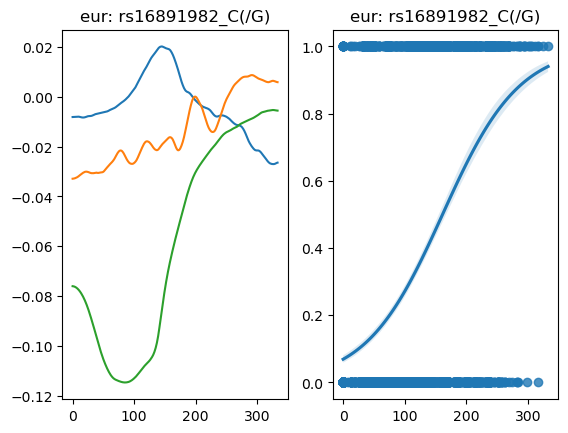

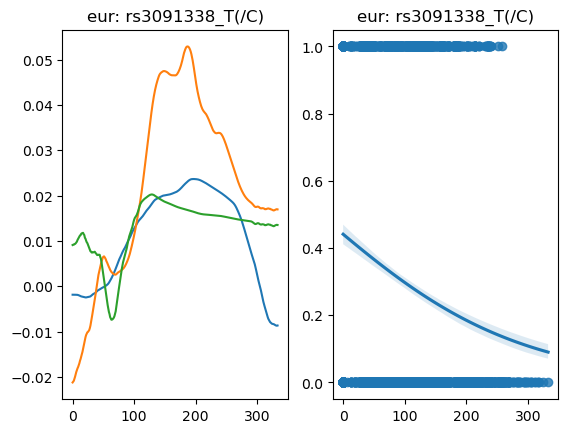

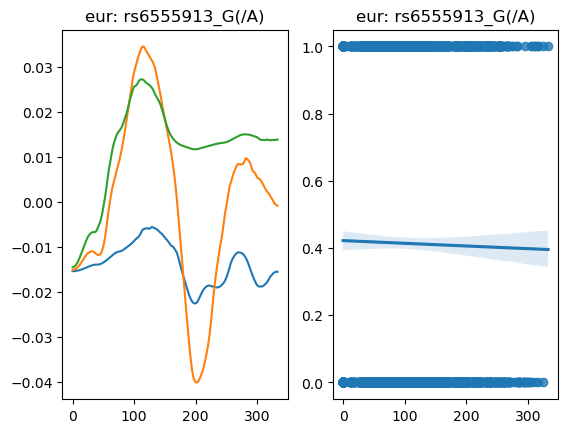

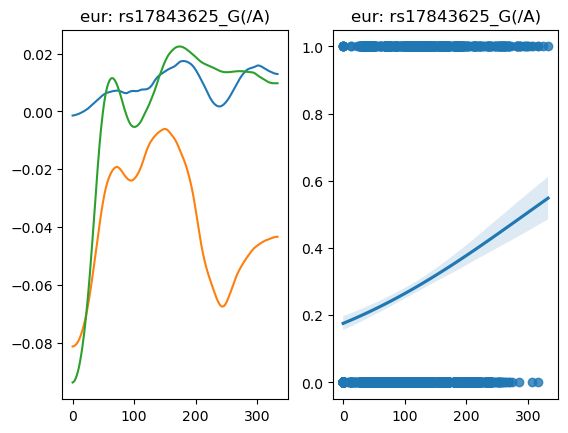

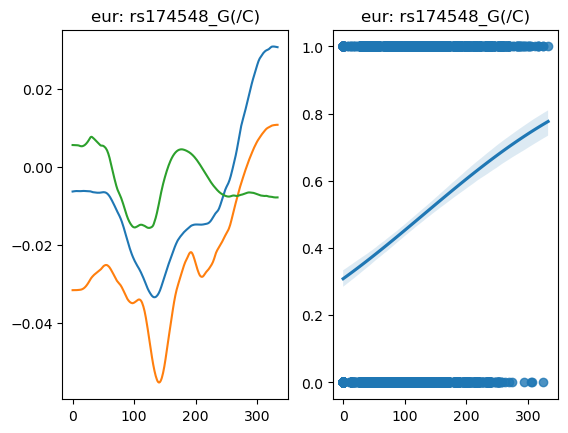

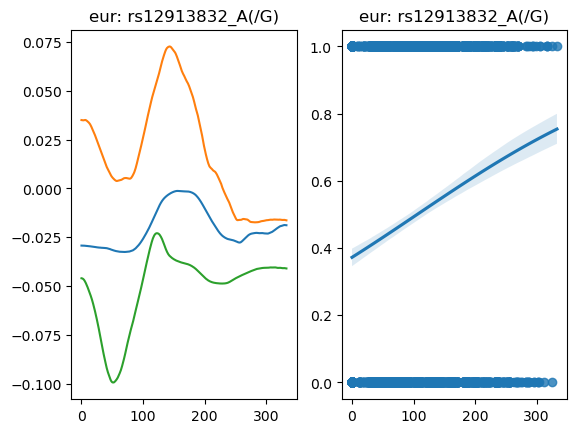

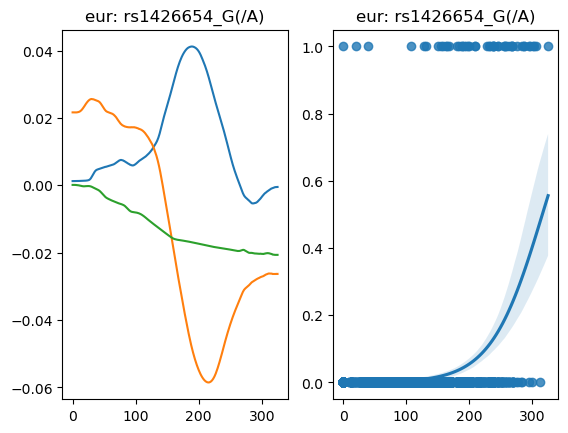

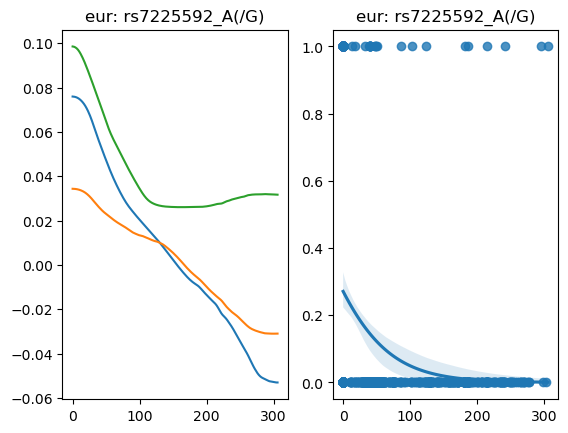

In [6]:
#Run for all EUR SNPs with k=3, alpha =1e4
pop="eur"
datasets, snps=read_data(pop, "_k3")
for data,snp in zip(datasets, snps): 
    print(snp)
    try:
        s=run_analysis(data, alpha=1e4
                       , beta=1, em_iterations=3)
        fig, axs = plt.subplots(ncols=2, nrows=1)
        axs[0].plot(s[:, 0], color="tab:blue", alpha=1)
        axs[0].plot(s[:, 1], color="tab:orange", alpha=1)
        axs[0].plot(s[:, 2], color="tab:green", alpha=1)
        a,b=[int(y) for x,y in zip(data.obs, data.t) if x[0]>0],[int(x[1]) for x,y in zip(data.obs, data.t) if x[0]>0]
        sns.regplot(x=a, y=b, logistic=True, ax=axs[1])
        axs[0].set_title(pop+": "+snp)
        axs[1].set_title(pop+": "+snp)
    except:
        print("Error: "+ snp)
